# LSTM Modeling
This Jupyter notebook creates two different LSTM architectures using TensorFlow: (1) binary output LSTM and (2) multilabel output LSTM. The two LSTM structures use the same input data.

In [1]:
### COMMENT OUT IF RUNNING LOCALLY (NOT VIA GOOGLE COLAB) ###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU.")
else:
    print("TensorFlow is using CPU.")


TensorFlow version: 2.17.0
TensorFlow is using GPU.


In [3]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 24.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import shap
from scipy.sparse import csr_matrix

def read_csv(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    print(csv_file_path)
    print('Shape:', df.shape)
    print(df.head())
    return df

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, \
roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# The Data Representation

- We have two different sources of data: the time-series data, and static data. The time series data has dimensions equivalent to `(# samples, # time stamps, # features)`. The static data has dimensions equivalent to `(# samples, # features)`.
- The time-series data will use an LSTM model since the architecture is designed to effectively work with long-range dependencies.
- The **LSTM model** will be bidirectional, providing us with additional advantages. A bidirectional LSTM processes the data both forward and backward, which is advantageous for clinical time-series data that can be influenced by both previous and subsequent information. Patterns in the clinical records can be better captured by knowing the additional context provided from both directions.
- The static data will be processed using a feed-forward network. The **feed-forward network (FFN)** is preferred over a single-layer perceptron (SLP) because it is more flexible. It can have multiple (hidden) layers to capture some of the more complex relationships between the input and output data.
- Papers like "An Extensive Data Processing Pipeline for MIMIC-IV" call a model like this a `hybrid LSTM model` because it uses both static data and time-series data for training.

## Read in the Data

In [6]:
input_data = read_csv('/content/drive/MyDrive/final_dfs/final_static_data.csv')

<ipython-input-4-bf2573342fe9>:18: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


/content/drive/MyDrive/final_dfs/final_static_data.csv
Shape: (109751, 1789)
   subject_id            charttime     hadm_id         duration  \
0    16925328  2151-05-25 15:03:00  20000024.0   75120000000000   
1    11146739  2190-01-15 14:41:00  20000057.0  255480000000000   
2    14546051  2130-12-10 00:00:00  20000069.0  175560000000000   
3    13074106  2135-05-20 00:00:00  20000102.0  296880000000000   
4    13559141  2174-12-06 00:00:00  20000347.0  177780000000000   

     microbiology_orgname curr_service   care_unit_group disposition  \
0                     NaN          MED         Emergency        HOME   
1                     NaN          MED         Emergency     UNKNOWN   
2  GRAM POSITIVE BACTERIA          OBS  Labor & Delivery        HOME   
3                     NaN          OBS  Labor & Delivery        HOME   
4     SERRATIA MARCESCENS          MED         Emergency     UNKNOWN   

   is_ed_visit  is_urgent_lab_event  ...                       race  \
0            0  

In [7]:
output_data = read_csv('/content/drive/MyDrive/final_dfs/target_outputs.csv')

/content/drive/MyDrive/final_dfs/target_outputs.csv
Shape: (19076, 5)
   subject_id  preeclampsia_output  preterm_output  hemorrhage_output  \
0    16925328                    0               0                  0   
1    11146739                    0               0                  0   
2    14546051                    0               0                  0   
3    13074106                    0               1                  1   
4    13559141                    0               0                  0   

   has_adverse_outcome  
0                    0  
1                    0  
2                    0  
3                    1  
4                    0  


## Generate the Model Architecture

### General Structure
- create the time series data input
- create the static data input
- create the concatenated output (LSTM and static data FFN)
- create the final classification layer (a dense layer)
- compule into the model with the appropriate optimizer, loss, and metrics

## Visualization-Related Functions

In [44]:
SAVE_FOLDER = 'capstone_imgs'
def gen_roc_curve(y_test, y_prob, plot_title, file_name):
  # ROC Curve
  auc_score = roc_auc_score(y_test, y_prob)
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)

  plt.figure(figsize=(10, 6))
  plt.plot(fpr, tpr, color='blue', label=f'ROC Curve(AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(plot_title)
  plt.legend(loc='lower right')
  plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}', bbox_inches='tight')
  plt.show()

def gen_roc_curve_multi(y_test, y_prob, plot_title, file_name, column_names):
    """
    Handle ROC Curve for each label independently, and plot separately.
    """
    num_labels = y_test.shape[1]
    plt.figure(figsize=(10, 6))

    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
        auc_score = roc_auc_score(y_test[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'{column_names[i]} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc='lower right')
    plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}.png', bbox_inches='tight')
    plt.show()

def gen_confusion_matrix(y_test, y_pred, plot_title, file_name):
  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(plot_title)
  plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}', bbox_inches='tight')
  plt.show()

def gen_confusion_matrix_multi(y_test, y_pred, plot_title, file_name, column_names):
    # Compute each heatmap separately for each target label
    num_labels = y_test.shape[1]

    for i in range(num_labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{plot_title} - {column_names[i]}')
        plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}_{column_names[i]}.png', bbox_inches='tight')
        plt.show()

def gen_precision_recall_curve(y_test, y_pred_prob, plot_title, file_name):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    ap_score = average_precision_score(y_test, y_pred_prob)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AP = {ap_score:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(plot_title)
    plt.legend(loc='lower left')
    plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}', bbox_inches='tight')
    plt.show()

def gen_precision_recall_curve_multi(y_test, y_pred_prob, plot_title, file_name, class_names):
    plt.figure()
    num_classes = y_test.shape[1]

    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
        average_precision = average_precision_score(y_test[:, i], y_pred_prob[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {class_names[i]} (AP = {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(plot_title)
    plt.legend(loc='upper right')
    plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}', bbox_inches='tight')
    plt.show()

### Define the models:
- create a base class for common preprocessing and training methods
- then create separate child classes for binary and multilabel classification
- Note that traditional SMOTE is not suited for multilabel classification - need to use a variation of SMOTE for handling the multilabel class
- MLSMOTE - multilabel SMOTE that extends SMOTE for multilabel classification, generates synthetic samples for each label while considering the correlations between labels
- We likely don't want to use MLSMOTE because it assumes that the labels are independent of each other - which we don't want to assume here
- can instead use class weight adjustment -- compute weights based on class frquencies and apply them in the loss function during training, plus use resampling via RandomOverSampler

In [30]:
class BaseLSTM:
    def __init__(self, timesteps, loss_function, test_size=0.3, pca_components=None):
        self.timesteps = timesteps
        self.loss_function = loss_function
        self.test_size = test_size
        self.pca_components = pca_components
        self.lstm_model = None

    def apply_pca(self, X):
        if self.pca_components:
            n_samples, timesteps, n_features = X.shape
            X_flattened = X.reshape(n_samples, timesteps * n_features)
            pca = PCA(n_components=self.pca_components)
            # shape: (n_samples, n_components)
            X_pca = pca.fit_transform(X_flattened)
            print(f"Reduced from {X.shape[0]} columns to {self.pca_components} PCA components")
            return X_pca
        return X

    def apply_resampling(self, X, y):
        # use placeholder values -- not implemented here because the implementation
        # varies between binary versus multilabel
        return X, y

    def build_model(self):
        raise NotImplementedError("Should be implemented by child classes")

    def cross_validate(self, X_resampled, y_resampled):

      kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

      auc_scores = []
      recall_scores = []
      y_test_all = []
      y_pred_prob_all = []
      y_pred_all = []

      for train_index, val_index in kf.split(X_resampled, y_resampled):
          print('Validating fold...')
          X_train, X_val = X_resampled[train_index], X_resampled[val_index]
          y_train, y_val = y_resampled[train_index], y_resampled[val_index]

          cls_weights = self.compute_class_weights(y_train)

          self.lstm_model = self.build_model()
          self.lstm_model.fit(
              x=X_train,
              y=y_train,
              validation_data=(X_val, y_val),
              batch_size=32,
              epochs=10,
              class_weight=cls_weights,
              verbose=1
          )

          y_pred_prob = self.lstm_model.predict(X_val)
          y_pred = self.predict_from_prob(y_pred_prob)

          # calculate the metrics we are interested in, for each fold
          fold_auc = roc_auc_score(y_val, y_pred_prob)
          fold_recall = recall_score(y_val, y_pred, average='binary')

          auc_scores.append(fold_auc)
          recall_scores.append(fold_recall)
          y_test_all.append(y_val)
          y_pred_prob_all.append(y_pred_prob)
          y_pred_all.append(y_pred)

      print('Cross-validated AUC:', np.mean(auc_scores))
      print('Cross-validated Recall:', np.mean(recall_scores))


    def train(self, X_time_series, y):
        X_pca = self.apply_pca(X_time_series)

        ## reshape
        X_pca_reshaped = None
        n_samples, n_components = X_pca.shape
        total_elements = n_samples * n_components
        if total_elements % (n_samples * self.timesteps) == 0:
          new_components = total_elements // (n_samples * self.timesteps)
          X_pca_reshaped = X_pca.reshape(n_samples, self.timesteps, new_components)
        else:
          raise ValueError("Cannot reshape PCA output due to mistmatch in dimensions")

        X_resampled, y_resampled = self.apply_resampling(X_pca_reshaped, y)

        self.cross_validate(X_resampled, y_resampled)

        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=self.test_size, random_state=23
        )

        cls_weights = self.compute_class_weights(y_train)

        self.lstm_model = self.build_model()
        model_fit = self.lstm_model.fit(
            x=X_train,
            y=y_train,
            validation_data=(X_test, y_test),
            batch_size=32,
            epochs=20,
            class_weight=cls_weights,
            verbose=1
        )

        y_pred_prob = self.lstm_model.predict(X_test)
        y_pred = self.predict_from_prob(y_pred_prob)

        train_auc = tf.keras.metrics.AUC()(y_test, y_pred_prob).numpy()
        train_recall = recall_score(y_test, y_pred, average='binary')

        print('Train AUC:', train_auc)
        print('Train Recall:', train_recall)

        report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
        print('Classification Report:')
        print(report)

        ### plot visualizations
        gen_roc_curve(y_test, y_pred_prob, 'Binary LSTM ROC Curve', 'binary_lstm_roc.png')
        gen_confusion_matrix(y_test, y_pred, 'Binary LSTM Confusion Matrix',
                             'binary_lstm_conf_matrix.png')
        gen_precision_recall_curve(y_test, y_pred_prob, 'Binary LSTM Precision-Recall Curve',
                                   'binary_lstm_prec_recall.png')

        return model_fit

    def predict_from_prob(self, y_pred_prob):
        raise NotImplementedError("Subclasses should implement this method.")

    def compute_class_weights(self, y):
        cls_weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(y),
            y=y
        )
        cls_weights = dict(enumerate(cls_weights))
        return cls_weights

    def predict(self, X_time_series):
        X_pca = self.apply_pca(X_time_series)

        X_pca_reshaped = None
        n_samples, n_components = X_pca.shape
        total_elements = n_samples * n_components
        if total_elements % (n_samples * self.timesteps) == 0:
          new_components = total_elements // (n_samples * self.timesteps)
          X_pca_reshaped = X_pca.reshape(n_samples, self.timesteps, new_components)
        else:
          raise ValueError("Cannot reshape PCA output due to mistmatch in dimensions")

        results = self.lstm_model.predict(X_pca_reshaped)
        return self.predict_from_prob(results)

    def save(self, file_path):
        self.lstm_model.save(file_path, overwrite=True)
        print(f'Model successfully saved to file path {file_path}')

    def load(self, file_path):
        self.lstm_model = tf.keras.models.load_model(file_path)
        print(f'Model successfully loaded from file path {file_path}')

In [12]:
class BinaryMIMICLSTM(BaseLSTM):
    def build_model(self):

        model = Sequential()

        # LSTM layer with reduced units
        model.add(LSTM(units=16, input_shape=(self.timesteps, self.pca_components)))
        # should use dropout between 0.2 and 0.5
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))

        # Dense output layer
        # use value of "1" here since this model has binary output
        # use sigmoid activation since goal is to classify into one of two classes
        model.add(Dense(1, activation='sigmoid'))

        # using legacy Adam optimizer (works better on M1 Mac)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss=self.loss_function, metrics=['AUC', 'Recall'])

        model.summary()
        return model

    def apply_resampling(self, X, y):
      # SMOTE expects 2 dimensions, so need to flatten
      X_flattened = X.reshape(X.shape[0], -1) #(n_samples, timesteps * num_features)
      smote = SMOTE(random_state=23)
      X_resampled, y_resampled = smote.fit_resample(X_flattened, y)
      # revert back to 3D
      n_samples = X_resampled.shape[0]
      n_features = X.shape[2] # from original representation of X
      X_reshaped = X_resampled.reshape(n_samples, self.timesteps, n_features)
      return X_reshaped, y_resampled

    def predict_from_prob(self, y_pred_prob):
      return (y_pred_prob > 0.5).astype(int).flatten()

In [43]:
class MultilabelMIMICLSTM(BaseLSTM):
  def __init__(self, timesteps, num_labels, loss_function, class_names,
               test_size=0.3, pca_components=None):
    super().__init__(timesteps, loss_function, test_size, pca_components)
    self.num_labels = num_labels
    self.class_names = class_names

  def build_model(self):
    model = Sequential()
    model.add(LSTM(units=16, input_shape=(self.timesteps, self.pca_components), return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(self.num_labels, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=self.loss_function, metrics=['AUC', 'Recall'])

    model.summary()
    return model


  def compute_class_weights(self, y):
      # Compute class weights for multilabel classification
      class_weights = {}
      num_labels = y.shape[1]
      print('about to compute weights')
      for i in range(num_labels):
          cls_weights = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=np.unique(y[:, i]),
              y=y[:, i]
          )
          class_weights[i] = {label: cls_weights[index] for index, label in enumerate(np.unique(y[:, i]))}
      print('weights created')
      print(class_weights)
      return class_weights

  def class_weights_to_sample_weights(self, y, class_weights):
    if len(y.shape) == 1:
        y = y[:, np.newaxis]

    sample_weights = np.ones(shape=(y.shape[0],), dtype=np.float32)

    for i in range(y.shape[1]):
        label_weights = class_weights.get(i, {})
        weight_for_label_1 = label_weights.get(1, 1)

        sample_indices = np.where(y[:, i] == 1)[0]

        sample_weights[sample_indices] *= weight_for_label_1

    return sample_weights

  def cross_validate(self, X, y):
    auc_scores = []
    recall_scores = []
    y_test_all = []
    y_pred_prob_all = []
    y_pred_all = []

    kf = KFold(n_splits=5, shuffle=True, random_state=23)

    for train_index, val_index in kf.split(X, y):
        print('Validating fold...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cls_weights = self.compute_class_weights(y_train)
        sample_weights = self.class_weights_to_sample_weights(y_train, cls_weights)

        self.lstm_model = self.build_model()
        self.lstm_model.fit(
            x=X_train,
            y=y_train,
            validation_data=(X_val, y_val),
            batch_size=32,
            epochs=10,
            sample_weight=sample_weights,
            verbose=1
        )

        y_pred_prob = self.lstm_model.predict(X_val)
        y_pred = self.predict_from_prob(y_pred_prob)

        fold_auc = []
        fold_recall = []

        for i in range(y_val.shape[1]):
            fold_auc.append(roc_auc_score(y_val[:, i], y_pred_prob[:, i]))
            fold_recall.append(recall_score(y_val[:, i], y_pred[:, i], average='binary'))

        auc_scores.append(np.mean(fold_auc))
        recall_scores.append(np.mean(fold_recall))
        y_test_all.append(y_val)
        y_pred_prob_all.append(y_pred_prob)
        y_pred_all.append(y_pred)

    auc_scores = np.array(auc_scores)
    recall_scores = np.array(recall_scores)

    print('Mean AUC scores across folds:', np.mean(auc_scores))
    print('Mean Recall scores across folds:', np.mean(recall_scores))
    return auc_scores, recall_scores, y_test_all, y_pred_prob_all, y_pred_all


  def train(self, X_time_series, y):
      X_pca = self.apply_pca(X_time_series)

      ## reshape
      X_pca_reshaped = None
      n_samples, n_components = X_pca.shape
      total_elements = n_samples * n_components
      if total_elements % (n_samples * self.timesteps) == 0:
        new_components = total_elements // (n_samples * self.timesteps)
        X_pca_reshaped = X_pca.reshape(n_samples, self.timesteps, new_components)
      else:
        raise ValueError("Cannot reshape PCA output due to mistmatch in dimensions")

      self.cross_validate(X_pca_reshaped, y)

      X_train, X_test, y_train, y_test = train_test_split(
          X_pca_reshaped, y, test_size=self.test_size, random_state=23
      )

      cls_weights = self.compute_class_weights(y_train)
      sample_weights = self.class_weights_to_sample_weights(y_train, cls_weights)


      self.lstm_model = self.build_model()
      model_fit = self.lstm_model.fit(
          x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          batch_size=32,
          epochs=10,
          sample_weight=sample_weights,
          verbose=1
      )

      y_pred_prob = self.lstm_model.predict(X_test)
      y_pred = self.predict_from_prob(y_pred_prob)

      train_auc = tf.keras.metrics.AUC()(y_test, y_pred_prob).numpy()
      train_recall = recall_score(y_test, y_pred, average='weighted')

      print('Train AUC:', train_auc)
      print('Train Recall (Weighted):', train_recall)

      if self.class_names is not None:
            report = classification_report(y_test, y_pred, target_names=self.class_names)
      else:
            report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(y_test.shape[1])])

      print(report)

      ### plot visualizations
      gen_roc_curve_multi(y_test, y_pred_prob, 'Multi-label LSTM ROC Curve', 'multi_lstm_roc_updated.png',
                          self.class_names)
      gen_confusion_matrix_multi(y_test, y_pred, 'Multi-label LSTM Confusion Matrix',
                            'multi_lstm_conf_matrix_updated.png', self.class_names)
      gen_precision_recall_curve_multi(y_test, y_pred_prob, 'Multi-label LSTM Precision-Recall Curve',
                                  'multi_lstm_prec_recall_updated.png', self.class_names)


      return model_fit

  def predict_from_prob(self, y_pred_prob):
    # we prefer higher recall, which is what lowering this threshold achieves
    return (y_pred_prob > 0.3).astype(int)

## Running the Binary LSTM Model

### Prepare the data, then train and evaluate the model

In [14]:
for col in input_data.columns:
    if pd.api.types.is_float_dtype(input_data[col]):
            input_data[col] = input_data[col].astype(int)

In [15]:
# these columns are either output cols, not necessary for the model, or are
# numeric features that will get handled separately
exclude_cols = ['has_adverse_outcome', 'subject_id', 'hadm_id', 'charttime', 'duration', 'age_at_admission',
                'mean_patient_weight']
feature_cols = [col for col in input_data.columns.tolist() if col not in exclude_cols]
# get dummies for all the categorical data
input_data = pd.get_dummies(input_data, columns=feature_cols)

In [16]:
# numeric data
columns_to_scale = input_data[['age_at_admission', 'mean_patient_weight']]

scaler = StandardScaler()
scaled_column = scaler.fit_transform(columns_to_scale)

scaled_column_df = pd.DataFrame(scaled_column, columns=['age_at_admission', 'mean_patient_weight'], index=input_data.index)
input_data = input_data.drop(columns=['age_at_admission', 'mean_patient_weight'])

# Add the scaled column back to the DataFrame
input_data = pd.concat([input_data, scaled_column_df], axis=1)

### Create Time Sequences

LSTM requires data to be in 3D array format of shape `(samples, timesteps, features)`

In [17]:
# sort and group by subject
# then create sequences where each sequence corresponds to a series of hadm_id events
input_data = input_data.sort_values(by=['subject_id', 'charttime'])

In [18]:
admission_counts = input_data.groupby('subject_id').size()
subject_ids = admission_counts[admission_counts >= 2].index
filtered_input_data = input_data[input_data['subject_id'].isin(subject_ids)]

In [19]:
filtered_input_data.shape

(106786, 3639)

In [20]:
filtered_input_data = pd.merge(filtered_input_data, output_data, on='subject_id', how='left')

In [21]:
filtered_input_data['has_adverse_outcome'].value_counts()

,count
has_adverse_outcome,
0,91716
1,15070


Notes on sequences and their relationship with PCA:
- PCA is applied to the features independently of their time order
- PCA does not inherently handle temporal sequences
- we should create the sequences first, then apply to PCA, then reshape as needed so that we are preserving the temporal structure

In [22]:
# Define timesteps -- hadm_id serves as the timestep
timesteps = 2
chunk_size = 10000
# define feature cols
exclude_cols = ['has_adverse_outcome', 'subject_id', 'hadm_id', 'charttime', 'duration',
                'preeclampsia_output', 'preterm_output', 'hemorrhage_output']
feature_cols = [col for col in filtered_input_data.columns.tolist() if col not in exclude_cols]
outcome_col = 'has_adverse_outcome'

# approaches for making this process less computationally expensive:
# (1) use vectorized operations using numpy library
# (2) process the data in chunks
def create_sequences_from_chunk(chunk, feature_cols, outcome_col, timesteps):
    # this function works for single outcome or multiple outcome columns
    features = chunk[feature_cols].values
    outcomes = chunk[outcome_col].values

    num_sequences = len(features) - timesteps

    if num_sequences <= 0:
        return np.array([]), np.array([])

    shape = (num_sequences, timesteps, features.shape[1])
    strides = (features.strides[0], features.strides[0], features.strides[1])
    sequences = np.lib.stride_tricks.as_strided(features, shape=shape, strides=strides)
    labels = outcomes[timesteps:]

    return sequences, labels

In [23]:
# results from all the processed chunks
all_sequences = []
all_labels = []
for start in range(0, len(filtered_input_data), chunk_size):
    end = min(start + chunk_size, len(filtered_input_data))
    chunk = filtered_input_data.iloc[start:end]
    sequences, labels = create_sequences_from_chunk(chunk, feature_cols, outcome_col, timesteps)
    if len(sequences) > 0:
        all_sequences.append(sequences)
        all_labels.append(labels)

In [24]:
X = np.concatenate(all_sequences, axis=0)
y = np.concatenate(all_labels, axis=0)

In [28]:
# multilabel example
all_sequences = []
all_labels = []

# define feature cols
exclude_cols = ['has_adverse_outcome', 'subject_id', 'hadm_id', 'charttime', 'duration',
                'preeclampsia_output', 'preterm_output', 'hemorrhage_output']
feature_cols = [col for col in filtered_input_data.columns.tolist() if col not in exclude_cols]
outcome_cols = ['preeclampsia_output', 'preterm_output', 'hemorrhage_output']
for start in range(0, len(filtered_input_data), chunk_size):
    end = min(start + chunk_size, len(filtered_input_data))
    chunk = filtered_input_data.iloc[start:end]
    sequences, labels = create_sequences_from_chunk(chunk, feature_cols, outcome_cols, timesteps)
    if len(sequences) > 0:
        all_sequences.append(sequences)
        all_labels.append(labels)

In [29]:
X_multi = np.concatenate(all_sequences, axis=0)
y_multi = np.concatenate(all_labels, axis=0)
y_multi_names = outcome_cols

### Determine appropriate number of PCA Components
- a practical number to use is around 5-20 components
- can use the explained variance ratio to help in choosing the number of components based on the amount of variance they explain
- example: choose enough components to explain 80% of the variance in the model

In [ ]:
# PCA requires format of (n_samples, n_features) but X is currently in
# the format of (n_samples, timesteps, n_features)
n_samples, timesteps, n_features = X.shape
X_flattened = X.reshape(n_samples, timesteps * n_features)
pca = PCA()
X_pca = pca.fit_transform(X_flattened)
# determine number of components that cumulatively determine 80% of the variable
cum_var = np.cumsum(pca.explained_variance_ratio_)
# get number of components
num_components = np.argmax(cum_var >= 0.8) + 1
print('Proposed number of components:', num_components)

Proposed number of components: 206
- about 200 components needed to explain 80% of the variance
- gives us a substantial decrease in feature complexity

### Create model!

In [25]:
timesteps = 2
loss_function = 'binary_crossentropy'
# start with smaller number of components for initial testing
pca_components = 200
bin_model = BinaryMIMICLSTM(timesteps, loss_function, test_size=0.3,
                            pca_components=pca_components)

Reduced from 106764 columns to 200 PCA components
Validating fold...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - AUC: 0.8021 - Recall: 0.9015 - loss: 0.5087 - val_AUC: 0.8440 - val_Recall: 0.9376 - val_loss: 0.4575
Epoch 2/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - AUC: 0.8403 - Recall: 0.9190 - loss: 0.4562 - val_AUC: 0.8601 - val_Recall: 0.9226 - val_loss: 0.4343
Epoch 3/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - AUC: 0.8572 - Recall: 0.9129 - loss: 0.4356 - val_AUC: 0.8682 - val_Recall: 0.9225 - val_loss: 0.4216
Epoch 4/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - AUC: 0.8677 - Recall: 0.9135 - loss: 0.4218 - val_AUC: 0.8722 - val_Recall: 0.9248 - val_loss: 0.4157
Epoch 5/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - AUC: 0.8727 - Recall: 0.9175 - loss: 0.4134 - val_AUC: 0.8765 - val_Recall: 0.9257 - val_loss: 0.4085
Epoch 6/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - AUC: 0.8775 - Recall: 0.9204 - loss: 0.4048 - val_AUC: 0.8801 - val_Recall: 0.9282 - val_loss: 0.4038
Epoch 7/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - AUC: 0.7980 - Recall: 0.9197 - loss: 0.5129 - val_AUC: 0.8399 - val_Recall: 0.9364 - val_loss: 0.4599
Epoch 2/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8383 - Recall: 0.9209 - loss: 0.4575 - val_AUC: 0.8548 - val_Recall: 0.9198 - val_loss: 0.4392
Epoch 3/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - AUC: 0.8541 - Recall: 0.9175 - loss: 0.4376 - val_AUC: 0.8659 - val_Recall: 0.9298 - val_loss: 0.4252
Epoch 4/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8671 - Recall: 0.9182 - loss: 0.4201 - val_AUC: 0.8707 - val_Recall: 0.9225 - val_loss: 0.4160
Epoch 5/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8721 - Recall: 0.9184 - loss: 0.4133 - val_AUC: 0.8760 - val_Recall: 0.9329 - val_loss: 0.4102
Epoch 6/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8774 - Recall: 0.9191 - loss: 0.4056 - val_AUC: 0.8790 - val_Recall: 0.9324 - val_loss: 0.4072
Epoch 7/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - AUC: 0.8043 - Recall: 0.9139 - loss: 0.5069 - val_AUC: 0.8341 - val_Recall: 0.9292 - val_loss: 0.4638
Epoch 2/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8405 - Recall: 0.9206 - loss: 0.4556 - val_AUC: 0.8513 - val_Recall: 0.9255 - val_loss: 0.4441
Epoch 3/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8543 - Recall: 0.9177 - loss: 0.4385 - val_AUC: 0.8622 - val_Recall: 0.9358 - val_loss: 0.4307
Epoch 4/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8643 - Recall: 0.9223 - loss: 0.4236 - val_AUC: 0.8680 - val_Recall: 0.9491 - val_loss: 0.4259
Epoch 5/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8722 - Recall: 0.9242 - loss: 0.4113 - val_AUC: 0.8727 - val_Recall: 0.9351 - val_loss: 0.4141
Epoch 6/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - AUC: 0.8765 - Recall: 0.9239 - loss: 0.4048 - val_AUC: 0.8762 - val_Recall: 0.9504 - val_loss: 0.4144
Epoch 7/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - AUC: 0.7983 - Recall: 0.9194 - loss: 0.5121 - val_AUC: 0.8390 - val_Recall: 0.9289 - val_loss: 0.4622
Epoch 2/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8419 - Recall: 0.9188 - loss: 0.4560 - val_AUC: 0.8547 - val_Recall: 0.9258 - val_loss: 0.4422
Epoch 3/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8569 - Recall: 0.9133 - loss: 0.4375 - val_AUC: 0.8640 - val_Recall: 0.9162 - val_loss: 0.4287
Epoch 4/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8677 - Recall: 0.9155 - loss: 0.4212 - val_AUC: 0.8682 - val_Recall: 0.9036 - val_loss: 0.4220
Epoch 5/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8728 - Recall: 0.9192 - loss: 0.4127 - val_AUC: 0.8739 - val_Recall: 0.9341 - val_loss: 0.4142
Epoch 6/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8784 - Recall: 0.9207 - loss: 0.4042 - val_AUC: 0.8765 - val_Recall: 0.9253 - val_loss: 0.4091
Epoch 7/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - AUC: 0.7967 - Recall: 0.9044 - loss: 0.5133 - val_AUC: 0.8400 - val_Recall: 0.9352 - val_loss: 0.4594
Epoch 2/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8399 - Recall: 0.9213 - loss: 0.4562 - val_AUC: 0.8544 - val_Recall: 0.9256 - val_loss: 0.4401
Epoch 3/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8564 - Recall: 0.9187 - loss: 0.4344 - val_AUC: 0.8614 - val_Recall: 0.9270 - val_loss: 0.4293
Epoch 4/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8669 - Recall: 0.9214 - loss: 0.4194 - val_AUC: 0.8684 - val_Recall: 0.9295 - val_loss: 0.4205
Epoch 5/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8734 - Recall: 0.9224 - loss: 0.4088 - val_AUC: 0.8725 - val_Recall: 0.9401 - val_loss: 0.4156
Epoch 6/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - AUC: 0.8785 - Recall: 0.9231 - loss: 0.4029 - val_AUC: 0.8769 - val_Recall: 0.9294 - val_loss: 0.4075
Epoch 7/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 24s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4012/4012 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - AUC: 0.8014 - Recall: 0.8646 - loss: 0.5119 - val_AUC: 0.8410 - val_Recall: 0.9200 - val_loss: 0.4604
Epoch 2/20
4012/4012 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - AUC: 0.8408 - Recall: 0.9153 - loss: 0.4570 - val_AUC: 0.8550 - val_Recall: 0.9016 - val_loss: 0.4423
Epoch 3/20
4012/4012 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - AUC: 0.8548 - Recall: 0.9133 - loss: 0.4388 - val_AUC: 0.8656 - val_Recall: 0.9299 - val_loss: 0.4275
Epoch 4/20
4012/4012 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - AUC: 0.8651 - Recall: 0.9124 - loss: 0.4253 - val_AUC: 0.8718 - val_Recall: 0.9221 - val_loss: 0.4187
Epoch 5/20
4012/4012 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - AUC: 0.8742 - Recall: 0.9162 - loss: 0.4133 - val_AUC: 0.8759 - val_Recall: 0.9059 - val_loss: 0.4129
Epoch 6/20
4012/4012 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - AUC: 0.8799 - Recall: 0.9150 - loss: 0.4037 - val_AUC: 0.8801 - val_Recall: 0.9278 - val_loss: 0.4082
Epoch 7/20
4012/4012 ━━━━━━━━━━━━━━━━━━━━ 22s 

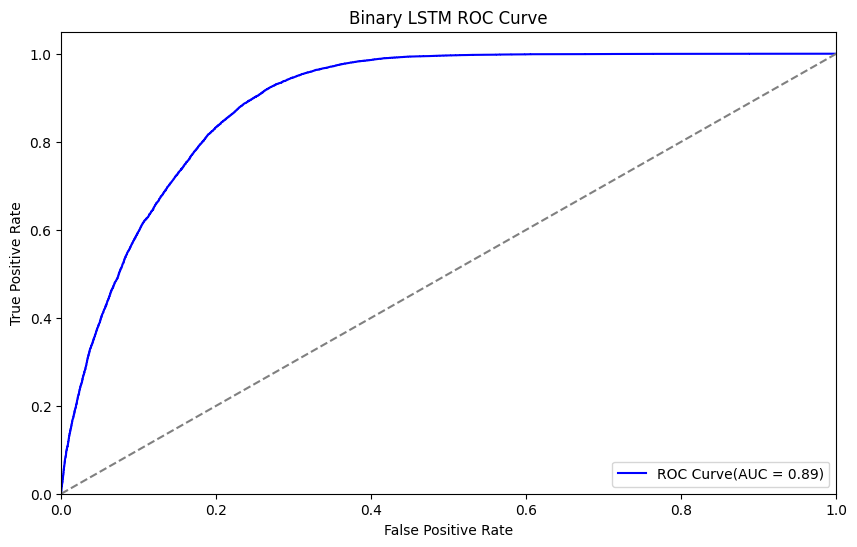

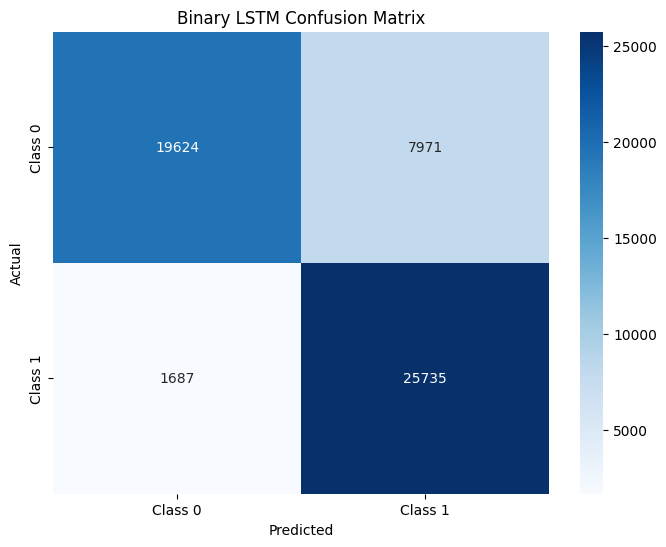

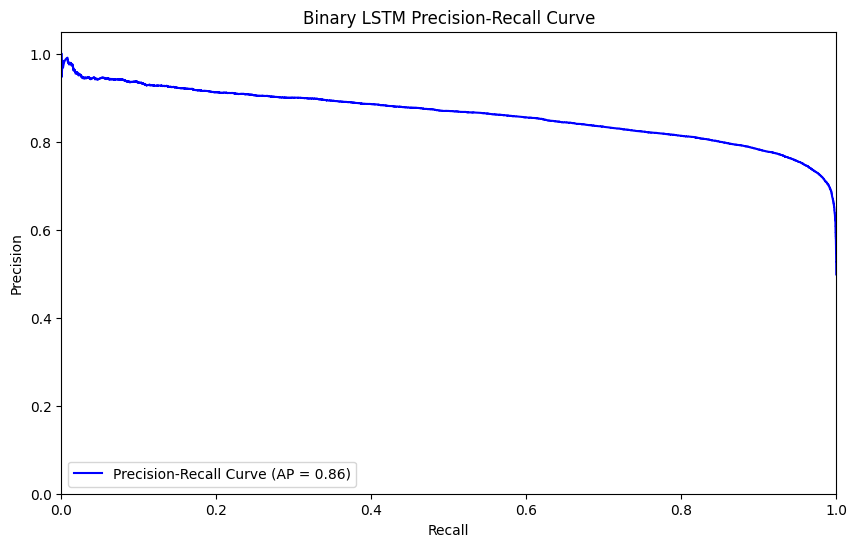

In [26]:
# train and evaluate
# "train" consists of applying PCA, applying resampling, creating train/test split,
# and ultimately training the model
model_fit = bin_model.train(X, y)

## Running the Multi-label LSTM Model

In [45]:
timesteps = 2
loss_function='binary_crossentropy'
pca_components = 200
num_labels = 3
class_names=y_multi_names
multi_model = MultilabelMIMICLSTM(timesteps, num_labels, loss_function, class_names,
                                  test_size=0.3,
                            pca_components=pca_components)

In [46]:
y_multi.shape

(106764, 3)

Reduced from 106764 columns to 200 PCA components
Validating fold...
about to compute weights
weights created
{0: {0: 0.5210720255743866, 1: 12.364070642733063}, 1: {0: 0.5254638743970863, 1: 10.317830393814932}, 2: {0: 0.5448241988160849, 1: 6.077344528248186}}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,531 (56.76 KB)

 Trainable params: 14,531 (56.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - AUC: 0.6660 - Recall: 0.8622 - loss: 3.5863 - val_AUC: 0.7646 - val_Recall: 0.9011 - val_loss: 0.6506
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7601 - Recall: 0.8520 - loss: 3.3778 - val_AUC: 0.7598 - val_Recall: 0.7329 - val_loss: 0.5138
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7597 - Recall: 0.7881 - loss: 3.2214 - val_AUC: 0.7624 - val_Recall: 0.8375 - val_loss: 0.5318
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7666 - Recall: 0.8045 - loss: 3.1313 - val_AUC: 0.7629 - val_Recall: 0.7264 - val_loss: 0.4925
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7691 - Recall: 0.7277 - loss: 2.9519 - val_AUC: 0.7660 - val_Recall: 0.8583 - val_loss: 0.5617
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7697 - Recall: 0.7843 - loss: 3.0701 - val_AUC: 0.7721 - val_Recall: 0.7572 - val_loss: 0.5151
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,531 (56.76 KB)

 Trainable params: 14,531 (56.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - AUC: 0.6566 - Recall: 0.8587 - loss: 3.6973 - val_AUC: 0.7583 - val_Recall: 0.8853 - val_loss: 0.5745
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7579 - Recall: 0.8666 - loss: 3.3188 - val_AUC: 0.7597 - val_Recall: 0.8561 - val_loss: 0.5825
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7600 - Recall: 0.8058 - loss: 3.2631 - val_AUC: 0.7608 - val_Recall: 0.8358 - val_loss: 0.5432
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7694 - Recall: 0.8050 - loss: 3.1236 - val_AUC: 0.7621 - val_Recall: 0.8604 - val_loss: 0.5912
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7674 - Recall: 0.7564 - loss: 3.0305 - val_AUC: 0.7595 - val_Recall: 0.7422 - val_loss: 0.4977
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7668 - Recall: 0.7573 - loss: 3.0643 - val_AUC: 0.7676 - val_Recall: 0.6981 - val_loss: 0.4738
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,531 (56.76 KB)

 Trainable params: 14,531 (56.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - AUC: 0.6604 - Recall: 0.8130 - loss: 3.6235 - val_AUC: 0.7629 - val_Recall: 0.8990 - val_loss: 0.5497
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - AUC: 0.7628 - Recall: 0.8849 - loss: 3.3156 - val_AUC: 0.7681 - val_Recall: 0.8413 - val_loss: 0.5209
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - AUC: 0.7644 - Recall: 0.8323 - loss: 3.1774 - val_AUC: 0.7738 - val_Recall: 0.8869 - val_loss: 0.6304
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - AUC: 0.7709 - Recall: 0.8319 - loss: 3.1524 - val_AUC: 0.7751 - val_Recall: 0.8141 - val_loss: 0.5393
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - AUC: 0.7733 - Recall: 0.7834 - loss: 3.0686 - val_AUC: 0.7717 - val_Recall: 0.7763 - val_loss: 0.5255
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - AUC: 0.7750 - Recall: 0.7514 - loss: 2.9751 - val_AUC: 0.7728 - val_Recall: 0.8066 - val_loss: 0.5631
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,531 (56.76 KB)

 Trainable params: 14,531 (56.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - AUC: 0.6509 - Recall: 0.8497 - loss: 3.7381 - val_AUC: 0.7489 - val_Recall: 0.8993 - val_loss: 0.6147
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - AUC: 0.7549 - Recall: 0.8730 - loss: 3.3136 - val_AUC: 0.7646 - val_Recall: 0.8987 - val_loss: 0.5832
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7630 - Recall: 0.8684 - loss: 3.2999 - val_AUC: 0.7595 - val_Recall: 0.8760 - val_loss: 0.6173
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7672 - Recall: 0.8350 - loss: 3.1465 - val_AUC: 0.7636 - val_Recall: 0.7822 - val_loss: 0.4961
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7687 - Recall: 0.7923 - loss: 3.0656 - val_AUC: 0.7641 - val_Recall: 0.7559 - val_loss: 0.4963
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7718 - Recall: 0.7572 - loss: 2.9794 - val_AUC: 0.7648 - val_Recall: 0.7645 - val_loss: 0.5065
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 15s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,531 (56.76 KB)

 Trainable params: 14,531 (56.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - AUC: 0.6625 - Recall: 0.7661 - loss: 3.5045 - val_AUC: 0.7775 - val_Recall: 0.9261 - val_loss: 0.6590
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7632 - Recall: 0.8695 - loss: 3.2922 - val_AUC: 0.7683 - val_Recall: 0.9180 - val_loss: 0.6352
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7648 - Recall: 0.8483 - loss: 3.1463 - val_AUC: 0.7698 - val_Recall: 0.8670 - val_loss: 0.5736
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7633 - Recall: 0.8075 - loss: 3.0783 - val_AUC: 0.7783 - val_Recall: 0.7883 - val_loss: 0.5284
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7693 - Recall: 0.7402 - loss: 2.9844 - val_AUC: 0.7709 - val_Recall: 0.7524 - val_loss: 0.5363
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7690 - Recall: 0.7271 - loss: 2.9755 - val_AUC: 0.7763 - val_Recall: 0.7574 - val_loss: 0.5298
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 14s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 16)                  │          13,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,531 (56.76 KB)

 Trainable params: 14,531 (56.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2336/2336 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - AUC: 0.7020 - Recall: 0.8126 - loss: 3.7162 - val_AUC: 0.7542 - val_Recall: 0.9220 - val_loss: 0.6407
Epoch 2/10
2336/2336 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.7637 - Recall: 0.8941 - loss: 3.3827 - val_AUC: 0.7557 - val_Recall: 0.8252 - val_loss: 0.5178
Epoch 3/10
2336/2336 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.7620 - Recall: 0.8557 - loss: 3.4158 - val_AUC: 0.7605 - val_Recall: 0.8181 - val_loss: 0.5430
Epoch 4/10
2336/2336 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.7613 - Recall: 0.7972 - loss: 3.1112 - val_AUC: 0.7601 - val_Recall: 0.8549 - val_loss: 0.5778
Epoch 5/10
2336/2336 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.7658 - Recall: 0.7954 - loss: 3.1332 - val_AUC: 0.7624 - val_Recall: 0.7897 - val_loss: 0.5070
Epoch 6/10
2336/2336 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.7695 - Recall: 0.7675 - loss: 2.9868 - val_AUC: 0.7633 - val_Recall: 0.7763 - val_loss: 0.5431
Epoch 7/10
2336/2336 ━━━━━━━━━━━━━━━━━━━━ 13s 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


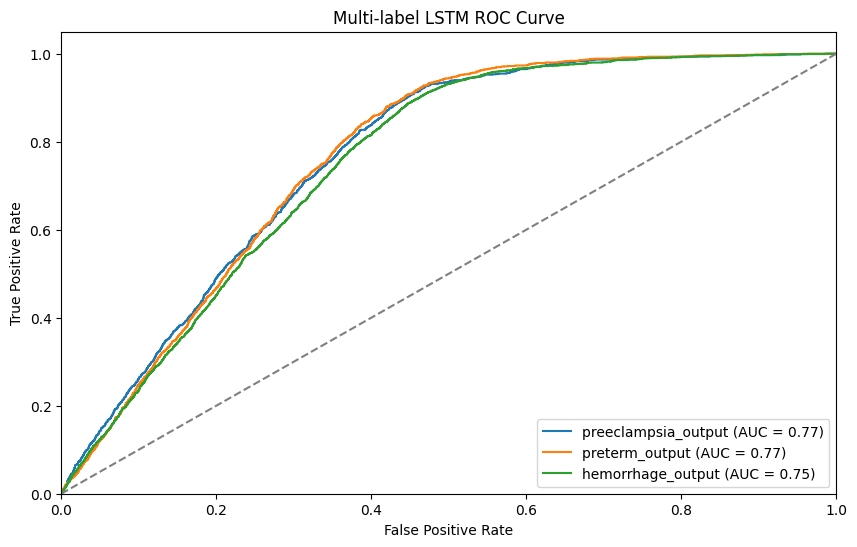

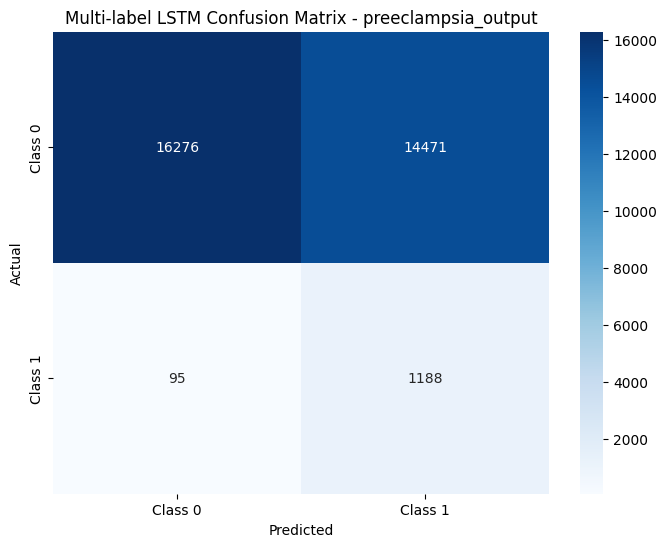

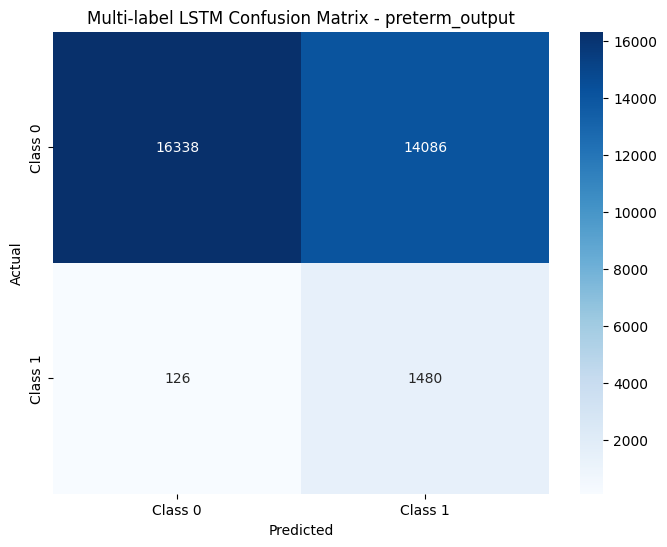

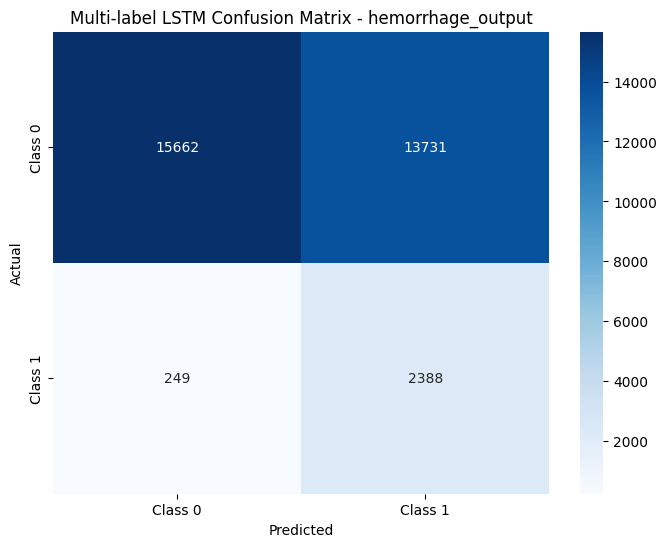

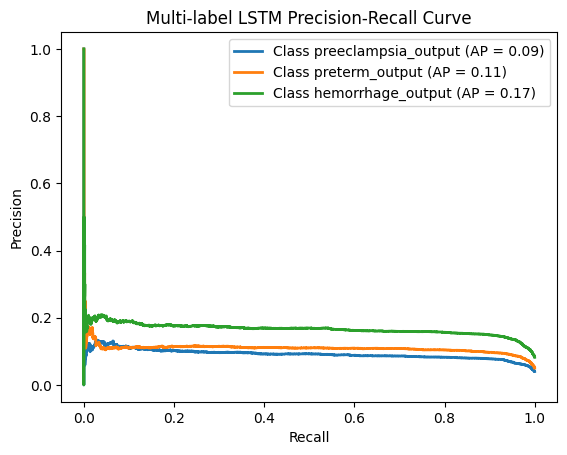

In [47]:
# train and evaluate
# "train" consists of applying PCA, applying resampling, creating train/test split,
# and ultimately training the model
model_fit = multi_model.train(X_multi, y_multi)